### Importing libriaries

In [51]:
import networkx as nx
# import urllib -- Did not work on my linux machine - using requests instead
import re
import tqdm
import collections
import requests
#import community.community_louvain as cl
import json
import matplotlib.pyplot as plt
import pandas as pd
import copy

## COMMUNITIES

UNDIRECTED GRAPH

In [57]:
G = nx.read_graphml('undirected.graphml')

   Community Size  Count
0               1     83
1               2      4
2            1241      1
3              12      1


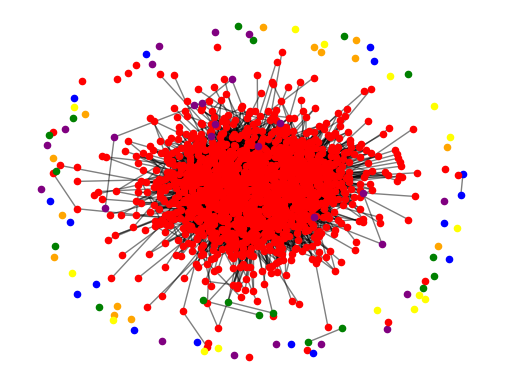

In [58]:
# detect communities using Girvan-Newman algorithm
communities_generator = nx.community.girvan_newman(D)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

# counting communities and their sizes
community_sizes = [len(community) for community in next_level_communities]

# create a df to display the size distribution of communities
df = pd.DataFrame(community_sizes, columns=["Community Size"])
size_counts = df["Community Size"].value_counts().reset_index()
size_counts.columns = ['Community Size', 'Count']
print(size_counts)

# visualize the graph with different colors for different communities
pos = nx.spring_layout(D, k=0.15) 
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange'] 

for i, community in enumerate(next_level_communities):
    nx.draw_networkx_nodes(G, pos, community, node_size=20, node_color=colors[i % len(colors)])

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.axis('off') 

# save the plot as an image file
plt.savefig('community_graph.png', format='png', dpi=500, bbox_inches='tight')

plt.show()


In [59]:
# Filter out outliers
outliers = [community for community in next_level_communities if len(community) in [1]]
for i, community in enumerate(outliers):
    print(f"Community {i+1} (Size: {len(community)}): {community}")
    
# Filter out communities with exactly 2 or 12 nodes
target_communities = [community for community in next_level_communities if len(community) in [2 , 12]]
for i, community in enumerate(target_communities):
    print(f"Community {i+1} (Size: {len(community)}): {community}")

Community 1 (Size: 1): {'20th'}
Community 2 (Size: 1): {'21st'}
Community 3 (Size: 1): {'High modernism'}
Community 4 (Size: 1): {'Reactionary bluegrass'}
Community 5 (Size: 1): {'Honky-tonk country'}
Community 6 (Size: 1): {'Western (Cowboy)'}
Community 7 (Size: 1): {'Ambient industrial'}
Community 8 (Size: 1): {'Hardcore breaks'}
Community 9 (Size: 1): {'Atmospheric drum and bass'}
Community 10 (Size: 1): {'Jazzstep'}
Community 11 (Size: 1): {'New Romantic#Styles of music'}
Community 12 (Size: 1): {'Livetronica'}
Community 13 (Size: 1): {'Melodic funk'}
Community 14 (Size: 1): {'Industrial hardcore'}
Community 15 (Size: 1): {'Disco house'}
Community 16 (Size: 1): {'Moombahsoul'}
Community 17 (Size: 1): {'Mid-tempo'}
Community 18 (Size: 1): {'Neurostep'}
Community 19 (Size: 1): {'Colour bass'}
Community 20 (Size: 1): {'American folk revival'}
Community 21 (Size: 1): {'Folk noir'}
Community 22 (Size: 1): {'Pizzica'}
Community 23 (Size: 1): {'Traditional blues verses'}
Community 24 (Siz

DIRECTED GRAPH

10 węzłów z największym stopniem:
List of electronic music genres: 345
List of styles of music: A–F: 283
List of rock genres: 236
List of styles of music: G–M: 178
Hip hop music: 157
List of styles of music: N–R: 136
List of styles of music: S–Z: 134
Heavy metal music: 120
New wave music: 101
List of hip hop genres: 96


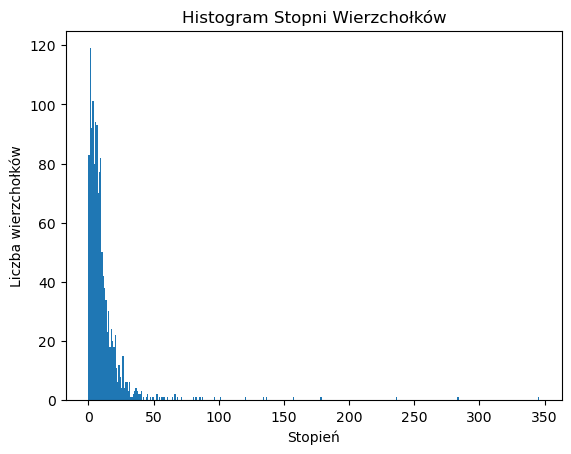

In [83]:
import networkx as nx
import matplotlib.pyplot as plt

stopnie = [(node, degree) for node, degree in G.degree()]
stopnie.sort(key=lambda x: x[1], reverse=True)

# Wybór 10 węzłów z największym stopniem
top_10_wierzcholkow = stopnie[:10]

# Wyświetlenie nazw 10 węzłów z największym stopniem
print("10 węzłów z największym stopniem:")
for node, degree in top_10_wierzcholkow:
    print(f"{node}: {degree}")

# Tworzenie histogramu stopni wierzchołków
stopnie_list = [degree for node, degree in G.degree()]
plt.hist(stopnie_list, bins=range(min(stopnie_list), max(stopnie_list) + 2))
plt.title('Histogram Stopni Wierzchołków')
plt.xlabel('Stopień')
plt.ylabel('Liczba wierzchołków')
plt.show()

In [84]:
import networkx as nx
import igraph as ig

nx_graph = G

vertex_mapping = {node: label for label, node in enumerate(nx_graph.nodes())}

igraph_graph = ig.Graph.TupleList(nx_graph.edges(), directed=False)

# communities FastGreedy
communities = igraph_graph.community_fastgreedy()
clusters = communities.as_clustering()

print("The number of found communities:", len(clusters))
for i, cluster in enumerate(clusters, start=1):
    # Zamiana numerów wierzchołków na ich etykiety
    cluster_labels = [list(nx_graph.nodes())[v] for v in cluster]
    print(f"Community {i}: {cluster_labels}")


The number of found communities: 14
Community 1: ['Music', 'music genre', 'genres', 'Andalusian classical music', 'Indian classical music', 'Korean court music', 'Persian classical music', 'Western classical music', 'Early music', 'Medieval music', 'Ars nova', 'Ars subtilior', 'Neo-Medieval music', 'Renaissance music', 'Baroque music', 'Galant music', 'Classical period (music)', 'Romantic music', '20th-century classical music', '20th', '21st-century classical music', '21st', 'Modernism (music)', 'High modernism', 'Postmodern music', 'Experimental music', 'Crossover music', 'Danger music', 'Drone music', 'Electroacoustic music', 'Industrial music', 'Instrumental', 'Musical improvisation', 'Musique concrète', 'Noise (music)', 'Outsider music', 'PC Music', 'Progressive music', 'Delta blues', 'Desert blues', 'Detroit blues', 'Gospel blues', 'Hokum blues', 'Soul blues', 'St. Louis blues (music)', 'Swamp blues', 'Talking blues', 'Texas blues', 'West Coast blues', 'Alternative country', 'Bake

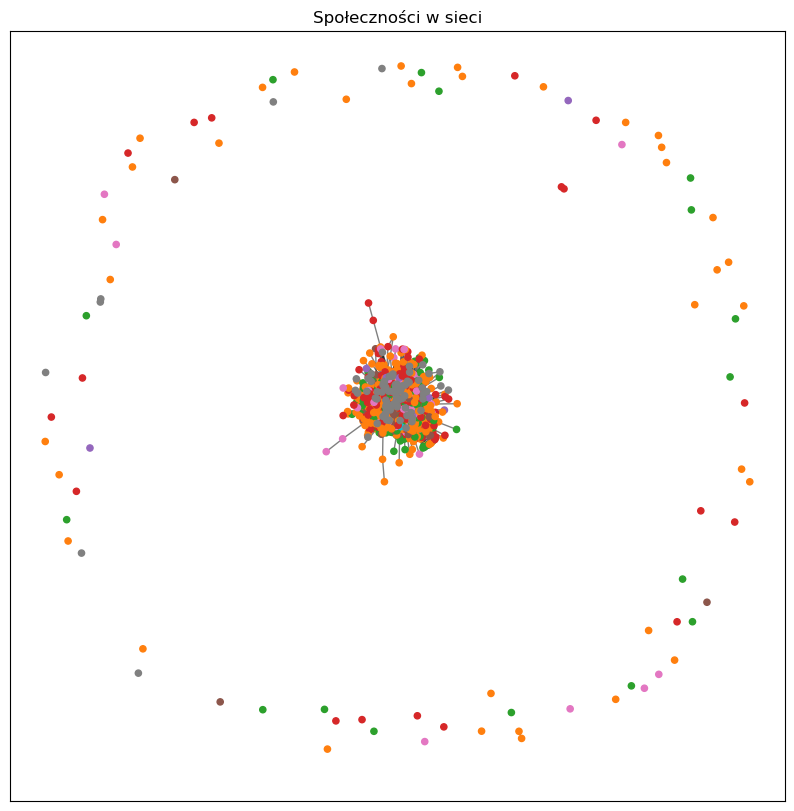

In [73]:
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Twoja sieć w NetworkX
nx_graph = G

# Konwersja z NetworkX do formatu używanego przez igraph
igraph_graph = ig.Graph.TupleList(nx_graph.edges(), directed=False)

# Wykrywanie społeczności za pomocą algorytmu FastGreedy
communities = igraph_graph.community_fastgreedy()
clusters = communities.as_clustering()

# Przygotowanie kolorów dla każdej społeczności
colors = list(mcolors.TABLEAU_COLORS.values())  # Używamy predefiniowanych kolorów
color_map = {node: 'grey' for node in nx_graph.nodes()}  # Domyślny kolor dla węzłów nieprzypisanych do społeczności

for i, cluster in enumerate(clusters, start=1):
    cluster_color = colors[i % len(colors)]  # Przypisz kolor dla społeczności
    for v in cluster:
        color_map[list(nx_graph.nodes())[v]] = cluster_color  # Przypisz kolor dla wierzchołka

# Rysowanie grafu
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(nx_graph)  # Układ węzłów

# Węzły i krawędzie grafu
nx.draw_networkx_edges(nx_graph, pos, alpha=0.5)
nx.draw_networkx_nodes(nx_graph, pos, node_color=[color_map[node] for node in nx_graph.nodes()], node_size=20)
#nx.draw_networkx_labels(nx_graph, pos)

plt.title("Społeczności w sieci")
plt.show()


Liczba znalezionych społeczności: 14
Społeczność 1: ['Music', 'music genre', 'genres', 'Andalusian classical music', 'Indian classical music', 'Korean court music', 'Persian classical music', 'Western classical music', 'Early music', 'Medieval music', 'Ars nova', 'Ars subtilior', 'Neo-Medieval music', 'Renaissance music', 'Baroque music', 'Galant music', 'Classical period (music)', 'Romantic music', '20th-century classical music', '20th', '21st-century classical music', '21st', 'Modernism (music)', 'High modernism', 'Postmodern music', 'Experimental music', 'Crossover music', 'Danger music', 'Drone music', 'Electroacoustic music', 'Industrial music', 'Instrumental', 'Musical improvisation', 'Musique concrète', 'Noise (music)', 'Outsider music', 'PC Music', 'Progressive music', 'Delta blues', 'Desert blues', 'Detroit blues', 'Gospel blues', 'Hokum blues', 'Soul blues', 'St. Louis blues (music)', 'Swamp blues', 'Talking blues', 'Texas blues', 'West Coast blues', 'Alternative country', 'B

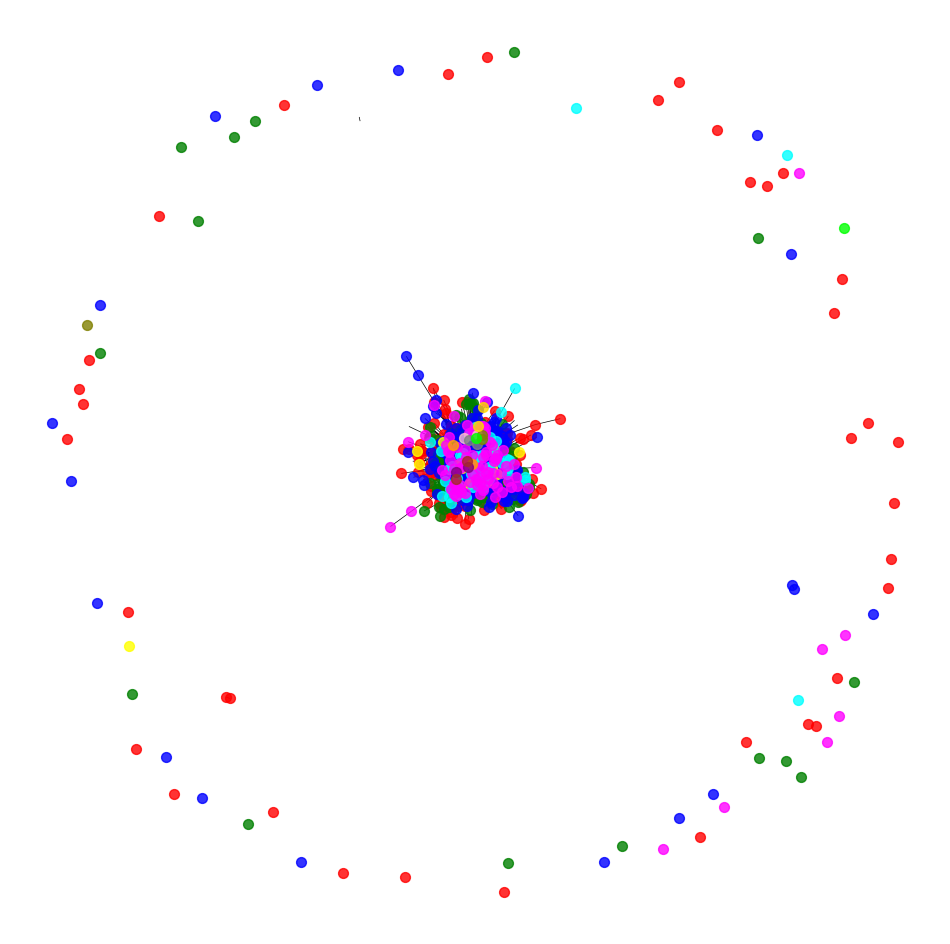

In [78]:
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt

# Twoja sieć w NetworkX
nx_graph = G

# Utworzenie mapowania z numerów wierzchołków na ich etykiety (nazwy)
vertex_mapping = {node: label for label, node in enumerate(nx_graph.nodes())}

# Konwersja z NetworkX do formatu używanego przez igraph
igraph_graph = ig.Graph.TupleList(nx_graph.edges(), directed=False)

# Wykrywanie społeczności za pomocą algorytmu FastGreedy
communities = igraph_graph.community_fastgreedy()
clusters = communities.as_clustering()

# Wypisanie wyników
print("Liczba znalezionych społeczności:", len(clusters))
for i, cluster in enumerate(clusters, start=1):
    # Zamiana numerów wierzchołków na ich etykiety
    cluster_labels = [list(nx_graph.nodes())[v] for v in cluster]
    print(f"Społeczność {i}: {cluster_labels}")

# Definiowanie kolorów dla klastrów
colors = [
    'red', 'green', 'blue', 'yellow', 'cyan', 
    'magenta', 'orange', 'purple', 'brown', 'pink', 
    'gray', 'olive', 'gold', 'lime'
]

# Ustawienie pozycji wierzchołków z grupowaniem klastrów
pos = nx.spring_layout(nx_graph, scale=2.0)  # Możesz dostosować skalę według potrzeb

# Rysowanie grafu z uwzględnieniem poprawek
plt.figure(figsize=(12, 12))  # Możesz dostosować rozmiar figury

for i, cluster in enumerate(clusters):
    cluster_nodes = [list(nx_graph.nodes())[v] for v in cluster]
    nx.draw_networkx_nodes(nx_graph, pos, nodelist=cluster_nodes, node_color=colors[i % len(colors)], node_size=50, alpha=0.8)

nx.draw_networkx_edges(nx_graph, pos, width=0.5)
plt.axis('off')  # Ukrycie osi
plt.show()



NetworkXError: Node 0 has no position.

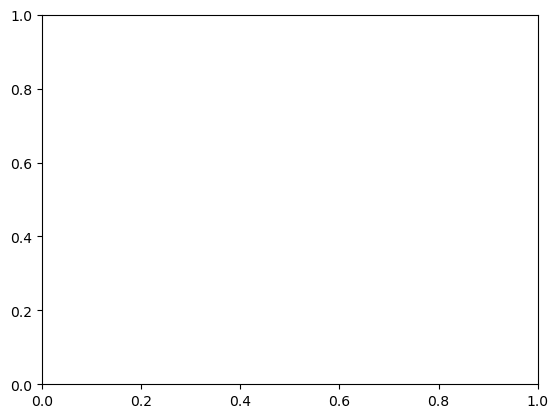

In [44]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Załóżmy, że graf G jest już załadowany i społeczności są wykryte
# G = ...

# Rysowanie grafu
pos = nx.spring_layout(G)  # Pozycja wierzchołków, np. przy użyciu algorytmu Fruchterman-Reingold

# Przypisanie kolorów dla różnych społeczności i rysowanie wierzchołków
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=[plt.cm.jet(i / len(communities))])

# Rysowanie krawędzi z przeźroczystością
nx.draw_networkx_edges(G, pos, alpha=0.1, style='dashed')

# Obliczanie środka ciężkości klastrów i rysowanie okręgów
for community in communities:
    # Oblicz środek ciężkości dla klastra
    centroid = np.mean([pos[node] for node in community], axis=0)
    radius = np.max([np.linalg.norm(np.array(pos[node]) - centroid) for node in community])  # Promień to odległość od najbardziej oddalonego wierzchołka

    # Rysuj okrąg wokół klastra
    circle = plt.Circle(centroid, radius, fill=False, color='black', linestyle='dashed', linewidth=1.5)
    plt.gca().add_patch(circle)

# Rysowanie etykiet wierzchołków (opcjonalnie)
# nx.draw_networkx_labels(G, pos)

plt.axis('off')
plt.show()


/var/folders/p5/8kc_v4413nsdcn4002zvhcv80000gn/T/ipykernel_94626/2586985189.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


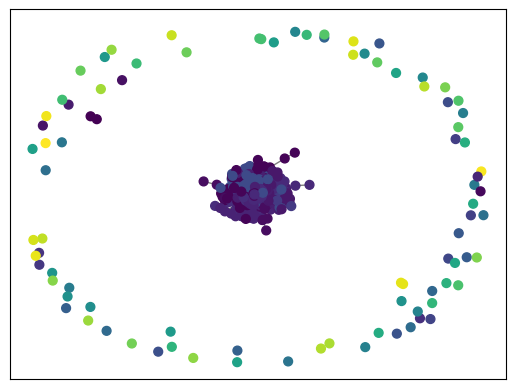

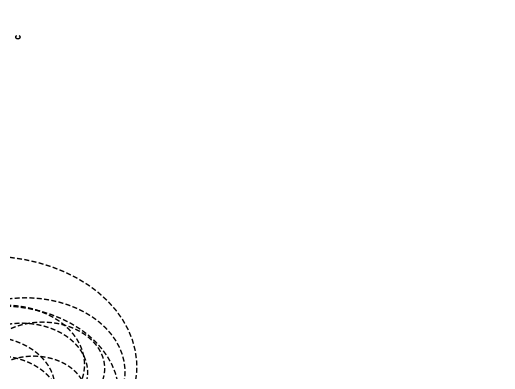

In [45]:
!pip install python-louvain

import community as community_louvain  # Często też znana jako python-louvain
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


# Wykrywanie społeczności w grafie G za pomocą algorytmu Louvain
partition = community_louvain.best_partition(G)

# Rysowanie grafu
pos = nx.spring_layout(G)  # Pozycja wierzchołków, np. przy użyciu algorytmu Fruchterman-Reingold

# Rysowanie wierzchołków z kolorami odpowiadającymi ich społeczności
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Pokazywanie grafu
plt.show()


# Tworzenie mapy społeczności do listy wierzchołków
communities = {}
for node, comm_id in partition.items():
    communities.setdefault(comm_id, []).append(node)

# Rysowanie okręgów wokół społeczności
for comm in communities.values():
    centroid = np.mean([pos[n] for n in comm], axis=0)
    radius = np.max([np.linalg.norm(np.array(pos[n]) - centroid) for n in comm])
    circle = plt.Circle(centroid, radius, edgecolor='black', facecolor='none', linestyle='--', linewidth=1)
    plt.gca().add_patch(circle)

plt.axis('off')
plt.show()


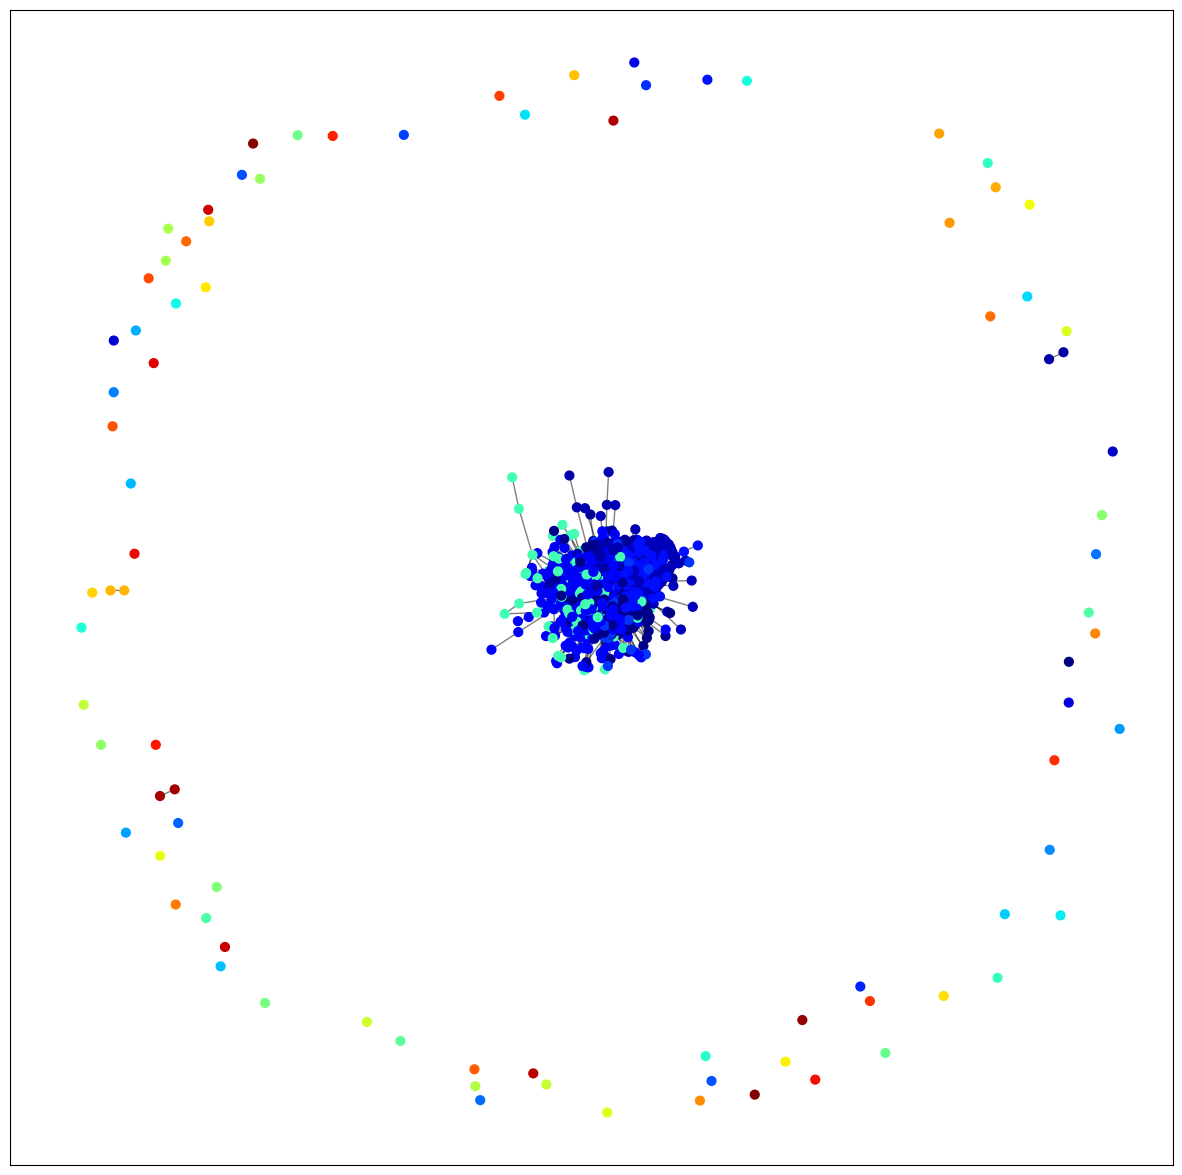

Number of societies: 96
Sizes of societies: Counter({10: 226, 5: 185, 41: 181, 12: 168, 13: 135, 1: 133, 2: 84, 11: 76, 4: 36, 17: 31, 68: 2, 92: 2, 3: 2, 6: 1, 7: 1, 8: 1, 14: 1, 15: 1, 16: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 34: 1, 35: 1, 36: 1, 38: 1, 39: 1, 40: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 93: 1, 94: 1, 95: 1, 0: 1, 33: 1, 37: 1, 9: 1})


In [85]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# Louvain - communities
partition = community_louvain.best_partition(G)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G) 
cmap = plt.cm.jet 


nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

from collections import Counter
community_sizes = Counter(partition.values())
print("Number of societies:", len(community_sizes))
print("Sizes of societies:", community_sizes)


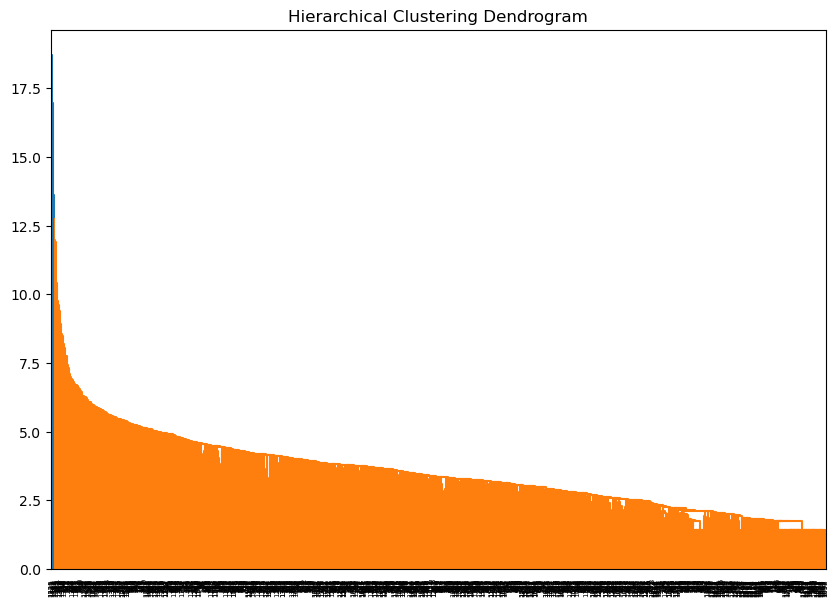

In [86]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

# Convert the graph to an adjacency matrix
adj_matrix = nx.to_numpy_array(G)

distance_matrix = 1 - adj_matrix
np.fill_diagonal(distance_matrix, 0) 

# Transform the distance matrix into the format required by scipy
dist_condensed = pdist(distance_matrix)

# Hierarchical clustering
Z = linkage(dist_condensed, method='average')  

# Visualizing the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


Cluster sizes from smallest to largest: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 132: 1, 133: 1, 134: 1, 136: 1, 137: 1, 13

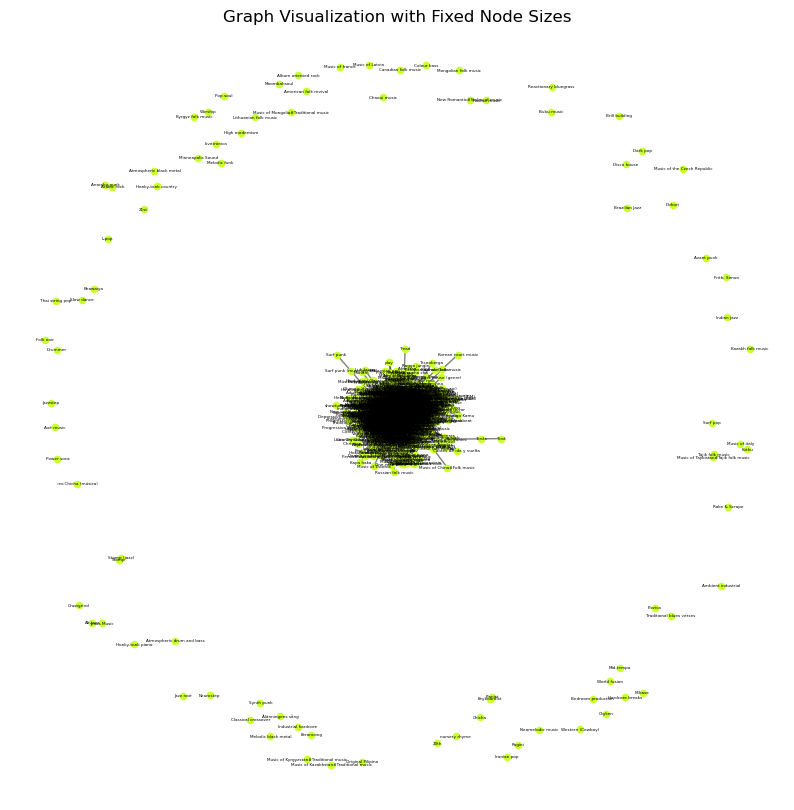

In [96]:
import matplotlib.pyplot as plt
import networkx as nx
import csv


# Hierarchical clustering to assign clusters
distance_threshold = 3.0
clusters = fcluster(Z, distance_threshold, criterion='distance')

# Assign clusters to nodes
cluster_dict = {node: cluster for node, cluster in zip(G.nodes(), clusters)}

# Analyze cluster characteristics and sort from smallest to largest
cluster_sizes = {i: list(clusters).count(i) for i in set(clusters)}
sorted_cluster_sizes = dict(sorted(cluster_sizes.items(), key=lambda item: item[1]))
print("Cluster sizes from smallest to largest:", sorted_cluster_sizes)

pos = nx.spring_layout(G)

# Draw the clusters using the positions
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, alpha=0.5)
for cluster, size in sorted_cluster_sizes.items():
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if cluster_dict[node] == cluster],
                           node_size=20,
                           node_color=[plt.cm.jet(cluster / max(sorted_cluster_sizes.keys()))])

# Draw labels if you prefer
nx.draw_networkx_labels(G, pos, font_size=3, font_color='black')

plt.title("Graph Visualization with Fixed Node Sizes")
plt.axis('off') 
plt.show()

# Save the cluster information and positions to CSV files
with open('clusters.csv', 'w', newline='') as csvfile:
    fieldnames = ['node', 'cluster']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for node, cluster in cluster_dict.items():
        writer.writerow({'node': node, 'cluster': cluster})

with open('clusters_positions.csv', 'w', newline='') as csvfile:
    fieldnames = ['node', 'pos_x', 'pos_y']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for node, position in pos.items():
        writer.writerow({'node': node, 'pos_x': position[0], 'pos_y': position[1]})


Cluster sizes from smallest to largest (excluding single-node clusters): {203: 2, 236: 2, 360: 2, 427: 2, 428: 2, 437: 2, 507: 2, 517: 2, 524: 2, 546: 2, 552: 2, 558: 2, 572: 2, 583: 2, 589: 2, 591: 2, 599: 2, 602: 2, 603: 2, 604: 2, 606: 2, 612: 2, 617: 2, 628: 2, 631: 2, 632: 2, 634: 2, 635: 2, 643: 2, 645: 2, 650: 2, 658: 2, 660: 2, 666: 2, 678: 2, 679: 2, 680: 2, 681: 2, 682: 2, 683: 2, 684: 2, 686: 2, 691: 2, 692: 2, 695: 2, 696: 2, 702: 2, 703: 2, 704: 2, 705: 2, 706: 2, 707: 2, 708: 2, 709: 2, 710: 2, 711: 2, 439: 3, 587: 3, 636: 3, 642: 3, 685: 3, 688: 3, 700: 3, 701: 3, 675: 4, 693: 4, 694: 4, 698: 4, 651: 5, 689: 5, 690: 6, 699: 7, 697: 35, 712: 174}


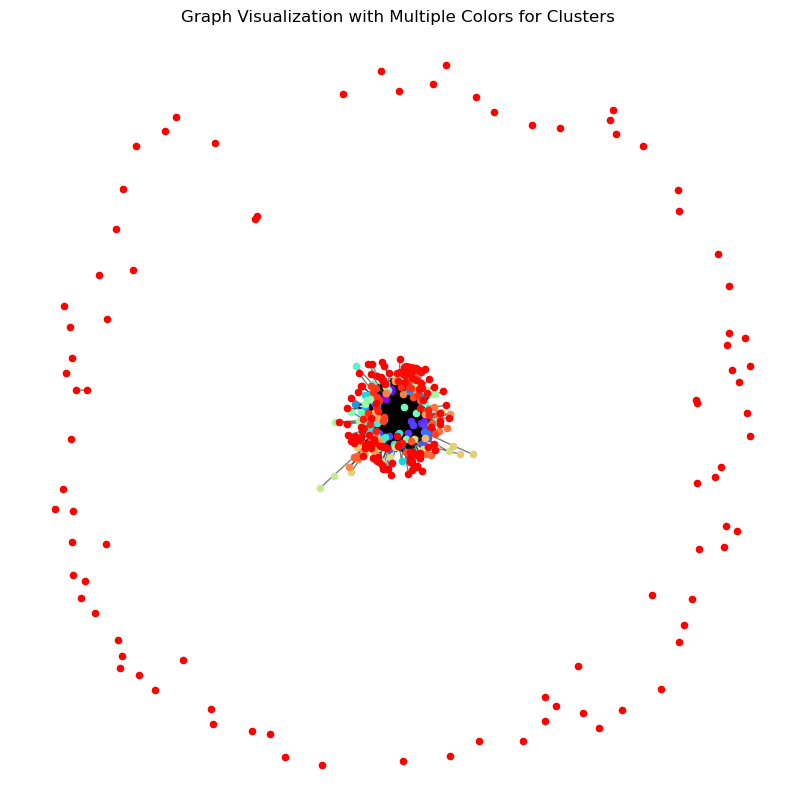

In [101]:
import matplotlib.pyplot as plt
import networkx as nx
import csv
from scipy.cluster.hierarchy import fcluster


# Hierarchical clustering to assign clusters
distance_threshold = 2.0
clusters = fcluster(Z, distance_threshold, criterion='distance')

# Assign clusters to nodes
cluster_dict = {node: cluster for node, cluster in zip(G.nodes(), clusters)}

# Analyze cluster characteristics and filter out clusters with only one node
cluster_sizes = {cluster: size for cluster, size in zip(*np.unique(clusters, return_counts=True)) if size > 1}

# Sort clusters from smallest to largest and exclude single-node clusters
sorted_cluster_sizes = dict(sorted(cluster_sizes.items(), key=lambda item: item[1]))
print("Cluster sizes from smallest to largest (excluding single-node clusters):", sorted_cluster_sizes)

# Prepare colors for each cluster
colors = plt.cm.rainbow(np.linspace(0, 1, len(sorted_cluster_sizes)))

# Draw the clusters using the positions
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, alpha=0.5)
for cluster, color in zip(sorted_cluster_sizes, colors):
    nodes_in_cluster = [node for node, cluster_id in cluster_dict.items() if cluster_id == cluster]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_cluster, node_size=20, node_color=[color])

plt.title("Graph Visualization with Multiple Colors for Clusters")
plt.axis('off')  
plt.show()

# Save the cluster information and positions to CSV files
with open('clusters.csv', 'w', newline='') as csvfile:
    fieldnames = ['node', 'cluster']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for node, cluster in cluster_dict.items():
        if cluster in sorted_cluster_sizes:  # Only include nodes in clusters with more than one node
            writer.writerow({'node': node, 'cluster': cluster})

with open('clusters_positions.csv', 'w', newline='') as csvfile:
    fieldnames = ['node', 'pos_x', 'pos_y']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for node, position in pos.items():
        writer.writerow({'node': node, 'pos_x': position[0], 'pos_y': position[1]})


Most important node in each cluster:
Number of clusters identified (excluding single-node clusters): 74
Cluster 681: Central node: Andalusian classical music
Cluster 708: Central node: Korean folk music
Cluster 712: Central node: Gospel blues
Cluster 688: Central node: Ars subtilior
Cluster 693: Central node: Galant music
Cluster 690: Central node: Classic female blues
Cluster 698: Central node: Desert blues
Cluster 699: Central node: St. Louis blues (music)
Cluster 643: Central node: Talking blues
Cluster 689: Central node: Acousmatic music
Cluster 660: Central node: Adult standards
Cluster 697: Central node: Kawaii future bass
Cluster 583: Central node: Reductionism (music)
Cluster 599: Central node: Suomisaundi
Cluster 694: Central node: Hardstep
Cluster 589: Central node: Dubtronica
Cluster 678: Central node: Synth-metal
Cluster 636: Central node: Rabòday
Cluster 696: Central node: Russ music
Cluster 203: Central node: UK drill
Cluster 236: Central node: Amapiano
Cluster 612: Centr

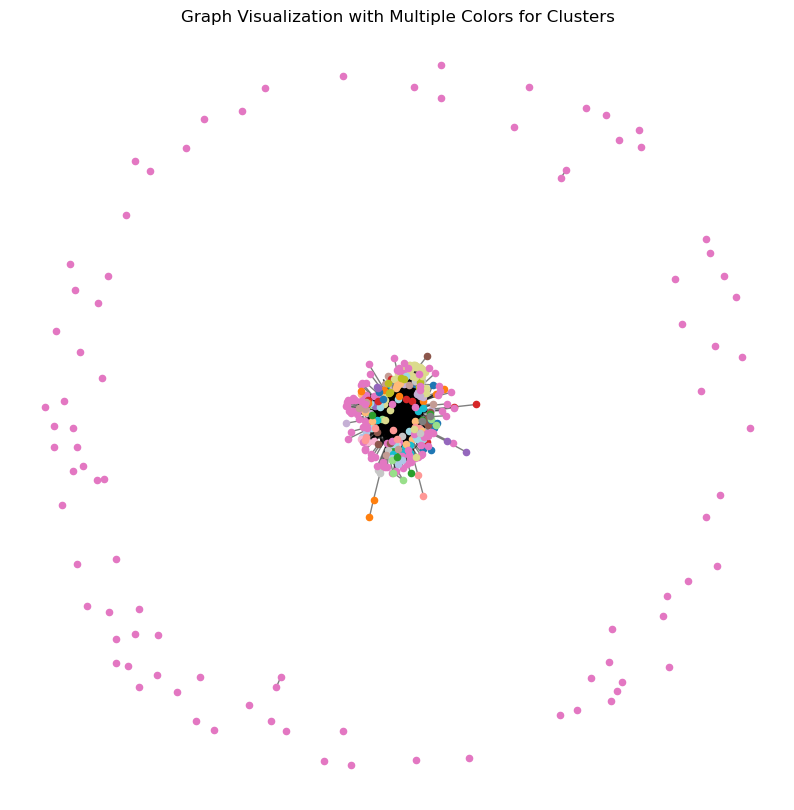

In [104]:
import matplotlib.pyplot as plt
import networkx as nx
import csv
from scipy.cluster.hierarchy import fcluster


# Hierarchical clustering to assign clusters
distance_threshold = 2.0
clusters = fcluster(Z, distance_threshold, criterion='distance')

# Assign clusters to nodes, skipping clusters with only one node
cluster_dict = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster) > 1}

# Calculate degree centrality for each node
degree_centrality = nx.degree_centrality(G)

# Find the most important node in each cluster
important_nodes = {}
for node, cluster in cluster_dict.items():
    if cluster not in important_nodes:
        important_nodes[cluster] = node
    elif degree_centrality[node] > degree_centrality[important_nodes[cluster]]:
        important_nodes[cluster] = node

# Print the most important nodes for each cluster
print("Most important node in each cluster:")
num_clusters = len(set(cluster_dict.values()))
print(f"Number of clusters identified (excluding single-node clusters): {num_clusters}")
for cluster, node in important_nodes.items():
    print(f"Cluster {cluster}: Central node: {node}")

pos = nx.spring_layout(G)  

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw nodes with different colors for each cluster
palette = plt.cm.tab20.colors  # Using a color palette for distinction
clusters_used = set(cluster_dict.values())
for cluster_id in clusters_used:
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[node for node, cluster in cluster_dict.items() if cluster == cluster_id],
        node_size=20,  # Smaller node size
        node_color=[palette[cluster_id % len(palette)]]  # Cycling through the color palette
    )

plt.title("Graph Visualization with Multiple Colors for Clusters")
plt.axis('off')
plt.show()

# Save the cluster information and positions to CSV files
with open('clusters.csv', 'w', newline='') as csvfile:
    fieldnames = ['node', 'cluster']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for node, cluster in cluster_dict.items():
        writer.writerow({'node': node, 'cluster': cluster})

with open('clusters_positions.csv', 'w', newline='') as csvfile:
    fieldnames = ['node', 'pos_x', 'pos_y']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for node, position in pos.items():
        writer.writerow({'node': node, 'pos_x': position[0], 'pos_y': position[1]})
